In [0]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from PIL import Image
from io import BytesIO
import requests

import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
cwd = os.getcwd()
print(cwd)
directory = '/content/gdrive/My Drive/data'
[x[0] for x in os.walk(directory)]

/content


['/content/gdrive/My Drive/data',
 '/content/gdrive/My Drive/data/validation_data',
 '/content/gdrive/My Drive/data/training_data',
 '/content/gdrive/My Drive/data/test_data']

In [0]:
IMG_DIM = (224, 224)

train_files = glob.glob('/content/gdrive/My Drive/data/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_files = glob.glob('/content/gdrive/My Drive/data/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1894, 224, 224, 3) 	Validation dataset shape: (948, 224, 224, 3)


In [0]:
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

(224, 224, 3)


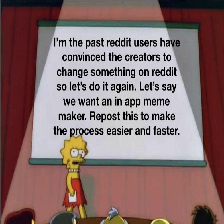

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [0]:
batch_size = 30
num_classes = 2
epochs = 100
input_shape = (224, 224, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505]) #0 is dank, 1 is not dank

['dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank', 'dank'] [0 0 0 0 0 0 0 0 0 0]


In [0]:
from keras.models import Model
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,Layer Type,Layer Name,Layer Trainable
10,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700aee10>,block3_pool,False
11,<keras.layers.convolutional.Conv2D object at 0x7fc4700aef98>,block4_conv1,False
12,<keras.layers.convolutional.Conv2D object at 0x7fc4700b7ba8>,block4_conv2,False
13,<keras.layers.convolutional.Conv2D object at 0x7fc4700bc748>,block4_conv3,False
14,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700bcf60>,block4_pool,False
15,<keras.layers.convolutional.Conv2D object at 0x7fc4700c2278>,block5_conv1,False
16,<keras.layers.convolutional.Conv2D object at 0x7fc4700c2cf8>,block5_conv2,False
17,<keras.layers.convolutional.Conv2D object at 0x7fc4700cb898>,block5_conv3,False
18,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700d1320>,block5_pool,False
19,<keras.layers.core.Flatten object at 0x7fc4863a7828>,flatten_1,False


(1, 7, 7, 512)


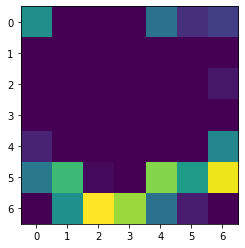

In [0]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [0]:
#unfreeze some layers
vgg_model.trainable = True

retrain_layers = ['block5_conv1', 'block4_conv1']
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in retrain_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   

,Layer Type,Layer Name,Layer Trainable
10,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700aee10>,block3_pool,False
11,<keras.layers.convolutional.Conv2D object at 0x7fc4700aef98>,block4_conv1,True
12,<keras.layers.convolutional.Conv2D object at 0x7fc4700b7ba8>,block4_conv2,True
13,<keras.layers.convolutional.Conv2D object at 0x7fc4700bc748>,block4_conv3,True
14,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700bcf60>,block4_pool,True
15,<keras.layers.convolutional.Conv2D object at 0x7fc4700c2278>,block5_conv1,True
16,<keras.layers.convolutional.Conv2D object at 0x7fc4700c2cf8>,block5_conv2,True
17,<keras.layers.convolutional.Conv2D object at 0x7fc4700cb898>,block5_conv3,True
18,<keras.layers.pooling.MaxPooling2D object at 0x7fc4700d1320>,block5_pool,True
19,<keras.layers.core.Flatten object at 0x7fc4863a7828>,flatten_1,True


In [0]:
# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)       

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)     

Epoch 1/100
100/100 [==============================] - 36s 364ms/step - loss: 0.7276 - accuracy: 0.4987 - val_loss: 0.7182 - val_accuracy: 0.4929
Epoch 2/100
100/100 [==============================] - 32s 321ms/step - loss: 0.6986 - accuracy: 0.5299 - val_loss: 0.6867 - val_accuracy: 0.5587
Epoch 3/100
100/100 [==============================] - 32s 324ms/step - loss: 0.6932 - accuracy: 0.5414 - val_loss: 0.7376 - val_accuracy: 0.5121
Epoch 4/100
100/100 [==============================] - 33s 329ms/step - loss: 0.6958 - accuracy: 0.5400 - val_loss: 0.7575 - val_accuracy: 0.5213
Epoch 5/100
100/100 [==============================] - 32s 323ms/step - loss: 0.6852 - accuracy: 0.5716 - val_loss: 0.6966 - val_accuracy: 0.5577
Epoch 6/100
100/100 [==============================] - 33s 329ms/step - loss: 0.6873 - accuracy: 0.5585 - val_loss: 0.6123 - val_accuracy: 0.5506
Epoch 7/100
100/100 [==============================] - 32s 324ms/step - loss: 0.6845 - accuracy: 0.5638 - val_loss: 0.8652 -

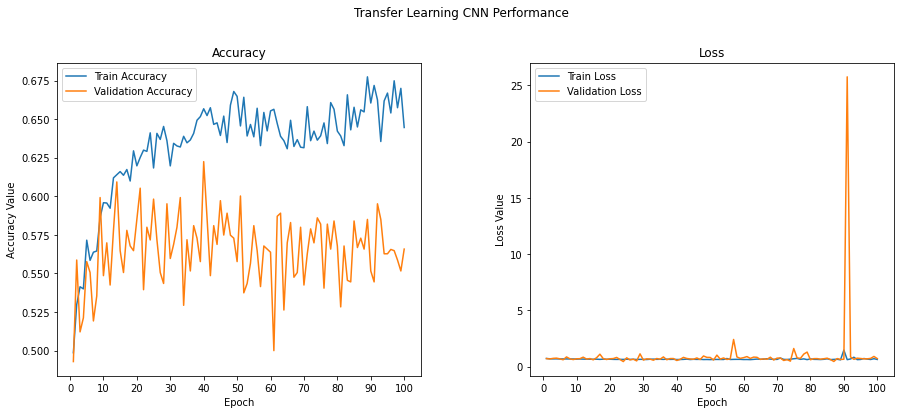

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('/content/gdrive/My Drive/models/tlearn_finetune_img_aug_vgg16_0.15_dropout_cnn.h5')